# Project


## data cleaning

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
air_quality = fetch_ucirepo(id=360) 
  
# data (as pandas dataframes) 
X = air_quality.data.features 

# metadata 
print(air_quality.metadata) 
  
# variable information 
print(air_quality.variables) 


{'uci_id': 360, 'name': 'Air Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/360/air+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/360/data.csv', 'abstract': 'Contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 9358, 'num_features': 15, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C59K5F', 'creators': ['Saverio Vito'], 'intro_paper': {'ID': 420, 'type': 'NATIVE', 'title': 'On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario', 'authors': 

In [199]:
# Check the shape of the dataset
print(f"X shape {X.shape}")

# 1. Basic Information
print("\n--- Basic Information ---")
print(X.info())  # Information about data types and non-null counts



X shape (9357, 15)

--- Basic Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB
None


In [200]:
print("\n--- Summary Statistics ---")
print(X.describe())  # Summary statistics for numerical features



--- Summary Statistics ---
            CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  9357.000000  9357.000000  9357.000000  9357.000000    9357.000000   
mean    -34.207524  1048.990061  -159.090093     1.865683     894.595276   
std      77.657170   329.832710   139.789093    41.380206     342.333252   
min    -200.000000  -200.000000  -200.000000  -200.000000    -200.000000   
25%       0.600000   921.000000  -200.000000     4.000000     711.000000   
50%       1.500000  1053.000000  -200.000000     7.900000     895.000000   
75%       2.600000  1221.000000  -200.000000    13.600000    1105.000000   
max      11.900000  2040.000000  1189.000000    63.700000    2214.000000   

           NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  9357.000000   9357.000000  9357.000000   9357.000000  9357.000000   
mean    168.616971    794.990168    58.148873   1391.479641   975.072032   
std     257.433866    321.993552   126.940455    467.210125

In [201]:
X.head


<bound method NDFrame.head of            Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0     3/10/2004  18:00:00     2.6         1360       150      11.9   
1     3/10/2004  19:00:00     2.0         1292       112       9.4   
2     3/10/2004  20:00:00     2.2         1402        88       9.0   
3     3/10/2004  21:00:00     2.2         1376        80       9.2   
4     3/10/2004  22:00:00     1.6         1272        51       6.5   
...         ...       ...     ...          ...       ...       ...   
9352   4/4/2005  10:00:00     3.1         1314      -200      13.5   
9353   4/4/2005  11:00:00     2.4         1163      -200      11.4   
9354   4/4/2005  12:00:00     2.4         1142      -200      12.4   
9355   4/4/2005  13:00:00     2.1         1003      -200       9.5   
9356   4/4/2005  14:00:00     2.2         1071      -200      11.9   

      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
0              1046      166          1056      113         

In [202]:
# Extract all columns with "GT" in their names as the target values
y = X.filter(like='GT')  # Select columns where "GT" appears in the name

In [203]:
# Remove all negative pollution values from y
mask_y = ~(y < 0).any(axis=1)  # Retain rows where no negative values exist in y

# Remove all negative pollution values and values below -50 for 'AH', 'T', and 'RH' in X
mask_X = ~(X.filter(like='PT08').lt(0).any(axis=1))  # Remove negative values in pollution columns
mask_X &= (X['AH'] >= -50) & (X['T'] >= -50) & (X['RH'] >= -50)  # Apply the condition for AH, T, and RH

# Combine masks
final_mask = mask_y & mask_X

# Apply the combined mask to X and y
X = X[final_mask]
y = y[final_mask]

# Check the shapes of the cleaned data
print(f"Original X shape: {X.shape}, Cleaned X shape: {X.shape}")
print(f"Original y shape: {y.shape}, Cleaned y shape: {y.shape}")

Original X shape: (827, 15), Cleaned X shape: (827, 15)
Original y shape: (827, 5), Cleaned y shape: (827, 5)


In [204]:
# Drop the target columns from the features
X_RNN = X.drop(columns=y.columns)

# Also drop non-relevant columns like "Date" and "Time"
X = X_RNN.drop(columns=['Date', 'Time'])

# Verify the result
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print("Features (X):")
print(X.head())
print("Targets (y):")
print(y.head())


Features shape: (827, 8)
Target shape: (827, 5)
Features (X):
   PT08.S1(CO)  PT08.S2(NMHC)  PT08.S3(NOx)  PT08.S4(NO2)  PT08.S5(O3)     T  \
0         1360           1046          1056          1692         1268  13.6   
1         1292            955          1174          1559          972  13.3   
2         1402            939          1140          1555         1074  11.9   
3         1376            948          1092          1584         1203  11.0   
4         1272            836          1205          1490         1110  11.2   

     RH      AH  
0  48.9  0.7578  
1  47.7  0.7255  
2  54.0  0.7502  
3  60.0  0.7867  
4  59.6  0.7888  
Targets (y):
   CO(GT)  NMHC(GT)  C6H6(GT)  NOx(GT)  NO2(GT)
0     2.6       150      11.9      166      113
1     2.0       112       9.4      103       92
2     2.2        88       9.0      131      114
3     2.2        80       9.2      172      122
4     1.6        51       6.5      131      116


In [205]:
# Remove all negative pollution values from y
mask_y = ~(y < 0).any(axis=1)  # Retain rows where no negative values exist in y

# Remove all negative pollution values and values below -50 for 'AH', 'T', and 'RH' in X
mask_X = ~(X.filter(like='PT08').lt(0).any(axis=1))  # Remove negative values in pollution columns
mask_X &= (X['AH'] >= -50) & (X['T'] >= -50) & (X['RH'] >= -50)  # Apply the condition for AH, T, and RH

# Combine masks
final_mask = mask_y & mask_X

# Apply the combined mask to X and y
X_clean = X[final_mask]
y_clean = y[final_mask]

# Check the shapes of the cleaned data
print(f"Original X shape: {X.shape}, Cleaned X shape: {X_clean.shape}")
print(f"Original y shape: {y.shape}, Cleaned y shape: {y_clean.shape}")

Original X shape: (827, 8), Cleaned X shape: (827, 8)
Original y shape: (827, 5), Cleaned y shape: (827, 5)


In [206]:
print(min(X['T']))

6.3


In [207]:
X_RNN.head

<bound method NDFrame.head of            Date      Time  PT08.S1(CO)  PT08.S2(NMHC)  PT08.S3(NOx)  \
0     3/10/2004  18:00:00         1360           1046          1056   
1     3/10/2004  19:00:00         1292            955          1174   
2     3/10/2004  20:00:00         1402            939          1140   
3     3/10/2004  21:00:00         1376            948          1092   
4     3/10/2004  22:00:00         1272            836          1205   
...         ...       ...          ...            ...           ...   
1226  4/30/2004  20:00:00         1449           1282           625   
1227  4/30/2004  21:00:00         1363           1152           684   
1228  4/30/2004  22:00:00         1371           1136           689   
1229  4/30/2004  23:00:00         1406           1107           718   
1230   5/1/2004   0:00:00         1425           1155           709   

      PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  
0             1692         1268  13.6  48.9  0.7578  
1        

In [208]:
# Convert Date and Time columns to datetime with the correct format
X_RNN['Date'] = pd.to_datetime(X_RNN['Date'], format='%m/%d/%Y')  # Adjust format to match your data
X_RNN['Time'] = pd.to_datetime(X_RNN['Time'], format='%H:%M:%S').dt.time

# Extract useful features from Date and Time
X_RNN['Year'] = X_RNN['Date'].dt.year
X_RNN['Month'] = X_RNN['Date'].dt.month
X_RNN['Day'] = X_RNN['Date'].dt.day
X_RNN['DayOfWeek'] = X_RNN['Date'].dt.dayofweek  # Monday=0, Sunday=6
X_RNN['Hour'] = pd.to_datetime(X_RNN['Time'], format='%H:%M:%S').dt.hour

# Drop original Date and Time columns 
X_RNN = X_RNN.drop(columns=['Date', 'Time'])

# View processed data
print(X_RNN.head())


   PT08.S1(CO)  PT08.S2(NMHC)  PT08.S3(NOx)  PT08.S4(NO2)  PT08.S5(O3)     T  \
0         1360           1046          1056          1692         1268  13.6   
1         1292            955          1174          1559          972  13.3   
2         1402            939          1140          1555         1074  11.9   
3         1376            948          1092          1584         1203  11.0   
4         1272            836          1205          1490         1110  11.2   

     RH      AH  Year  Month  Day  DayOfWeek  Hour  
0  48.9  0.7578  2004      3   10          2    18  
1  47.7  0.7255  2004      3   10          2    19  
2  54.0  0.7502  2004      3   10          2    20  
3  60.0  0.7867  2004      3   10          2    21  
4  59.6  0.7888  2004      3   10          2    22  


### Scaling

In [209]:
# Add cyclical encoding for Hour and DayOfWeek
X_RNN['Hour_sin'] = np.sin(2 * np.pi * X_RNN['Hour'] / 24)
X_RNN['Hour_cos'] = np.cos(2 * np.pi * X_RNN['Hour'] / 24)
X_RNN['DayOfWeek_sin'] = np.sin(2 * np.pi * X_RNN['DayOfWeek'] / 7)
X_RNN['DayOfWeek_cos'] = np.cos(2 * np.pi * X_RNN['DayOfWeek'] / 7)

# Drop raw Hour and DayOfWeek if not needed
X_RNN = X_RNN.drop(columns=['Hour', 'DayOfWeek'])
print("After Cyclical Encoding:")
print(X_RNN)


After Cyclical Encoding:
      PT08.S1(CO)  PT08.S2(NMHC)  PT08.S3(NOx)  PT08.S4(NO2)  PT08.S5(O3)  \
0            1360           1046          1056          1692         1268   
1            1292            955          1174          1559          972   
2            1402            939          1140          1555         1074   
3            1376            948          1092          1584         1203   
4            1272            836          1205          1490         1110   
...           ...            ...           ...           ...          ...   
1226         1449           1282           625          2100         1569   
1227         1363           1152           684          1951         1495   
1228         1371           1136           689          1927         1471   
1229         1406           1107           718          1872         1384   
1230         1425           1155           709          1936         1789   

         T    RH      AH  Year  Month  Day  Hour_s

In [210]:
from sklearn.preprocessing import StandardScaler

# Initialize scalers 
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scale X and y 
X_scaled_RNN = scaler_X.fit_transform(X_RNN)
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)


In [211]:
X_scaled.shape

(827, 8)

In [212]:
from sklearn.model_selection import train_test_split
X_train_RNN, X_test_RNN,y_train_RNN, y_test_RNN = train_test_split(X_scaled_RNN,y_scaled, test_size=0.2)

X_train, X_test,y_train, y_test = train_test_split(X_scaled,y_scaled, test_size=0.2)

In [213]:
# Debug shapes
print(f"Original X_train_RNN shape: {X_train_RNN.shape}")

# Set time_steps to fit the data
time_steps = 5  # Adjust as needed (must be ≤ feature count)
if X_train_RNN.shape[1] % time_steps != 0:
    raise ValueError(
        f"Number of features ({X_train_RNN.shape[1]}) must be divisible by time_steps ({time_steps})."
    )

n_features = X_train_RNN.shape[1] // time_steps

# Reshape for RNN
X_train_RNN = X_train_RNN.reshape(-1, time_steps, n_features)
X_test_RNN = X_test_RNN.reshape(-1, time_steps, n_features)

print(f"New X_train_RNN shape: {X_train_RNN.shape}")
print(f"New X_test_RNN shape: {X_test_RNN.shape}")


Original X_train_RNN shape: (661, 15)
New X_train_RNN shape: (661, 5, 3)
New X_test_RNN shape: (166, 5, 3)


In [214]:
X_train.shape

(661, 8)

In [215]:
y_train.shape

(661, 5)

### data analysis

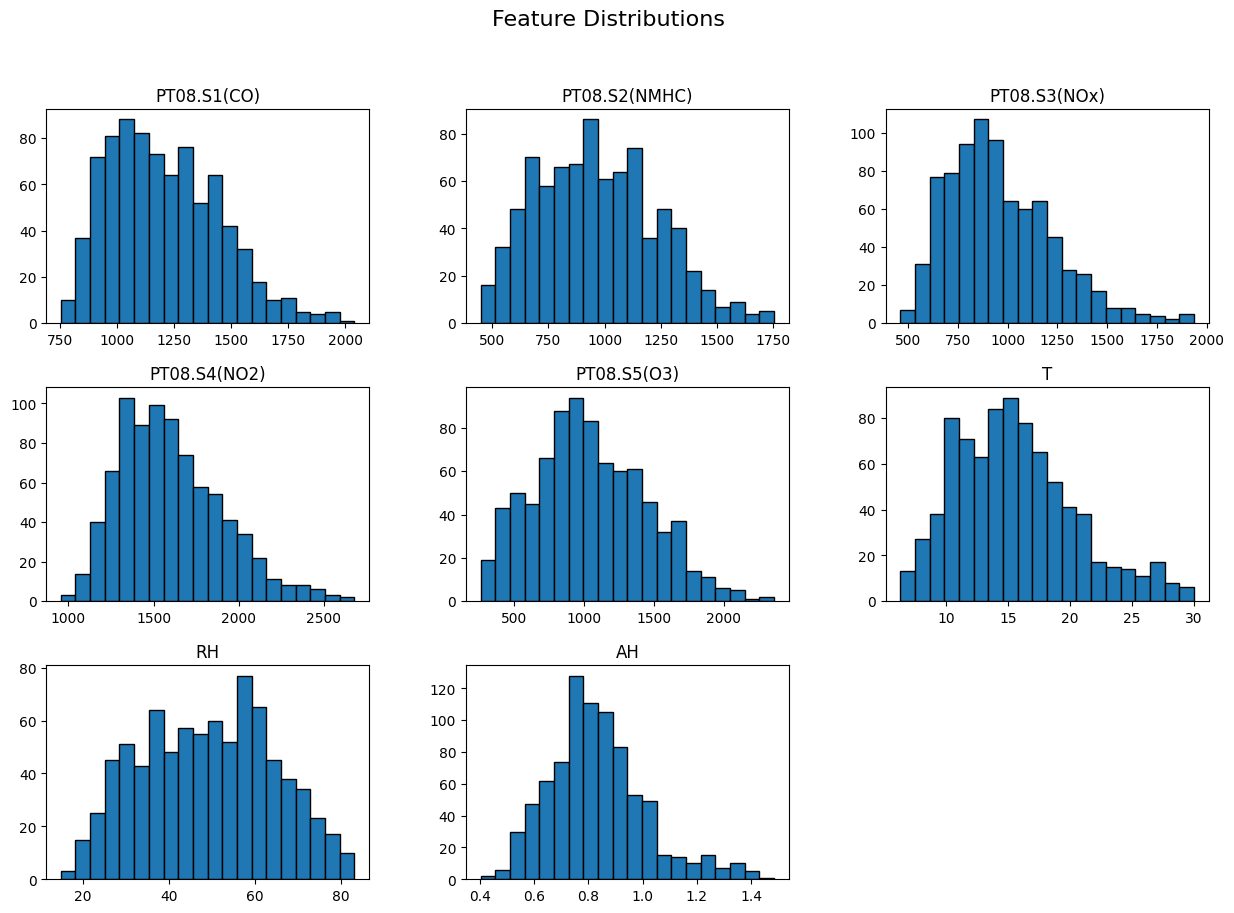

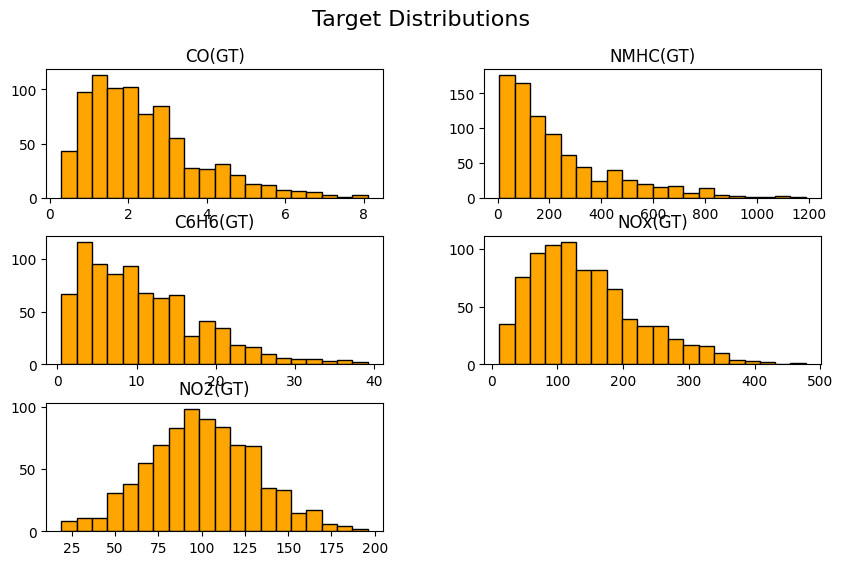

In [216]:
import matplotlib.pyplot as plt

# Plot histograms for features (X) and targets (y)
X.hist(figsize=(15, 10), bins=20, grid=False, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

y.hist(figsize=(10, 6), bins=20, grid=False, color='orange', edgecolor='black')
plt.suptitle("Target Distributions", fontsize=16)
plt.show()


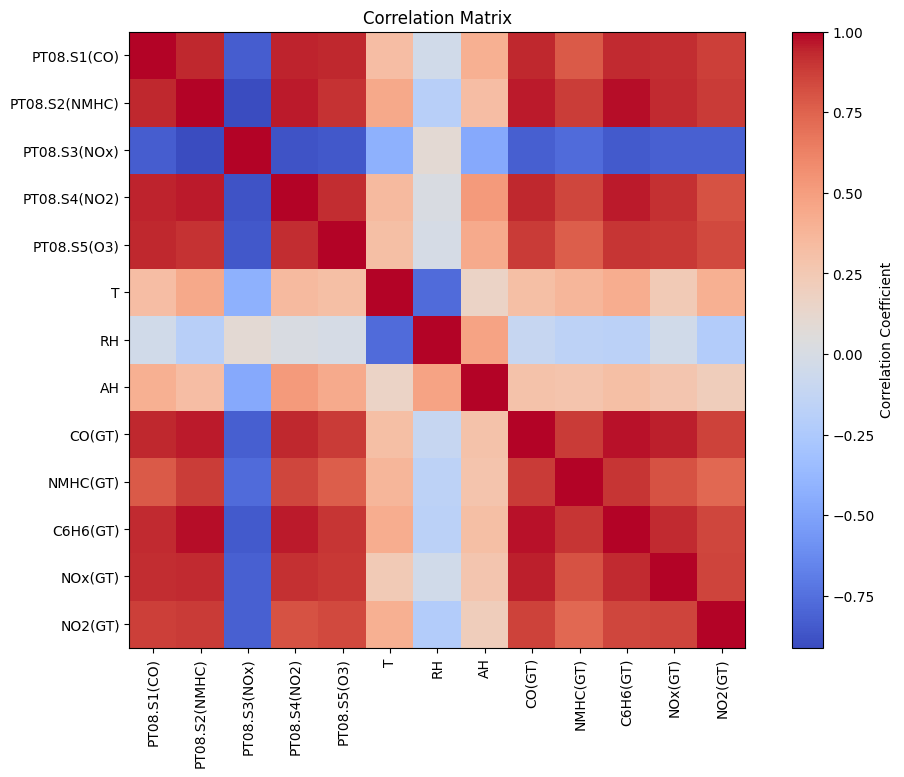

In [217]:
import pandas as pd

# Compute the correlation matrix
correlation_matrix = pd.concat([X, y], axis=1).corr()

# Visualize the correlation matrix using Matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label="Correlation Coefficient")
plt.title("Correlation Matrix")
plt.xticks(range(correlation_matrix.shape[0]), correlation_matrix.columns, rotation=90)
plt.yticks(range(correlation_matrix.shape[0]), correlation_matrix.index)
plt.show()


## Creating and training the model 


### I chose two models, a Deep Neural Network and a Recurrent Neural Network

In [218]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout


rnn = Sequential([
    SimpleRNN(64, activation='relu', input_shape=(5, 3)),  # (time_steps, features)
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(y_train_RNN.shape[1])  # Output shape matches your target
])


# Compile the model
rnn.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [219]:
history = rnn.fit(
    X_train_RNN, 
    y_train_RNN,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
17/17 [==============================] - 1s 16ms/step - loss: 0.9788 - mae: 0.7716 - val_loss: 0.9843 - val_mae: 0.7665
Epoch 2/50
17/17 [==============================] - 0s 4ms/step - loss: 0.7967 - mae: 0.6787 - val_loss: 0.7450 - val_mae: 0.6475
Epoch 3/50
17/17 [==============================] - 0s 4ms/step - loss: 0.4996 - mae: 0.5304 - val_loss: 0.2787 - val_mae: 0.3941
Epoch 4/50
17/17 [==============================] - 0s 4ms/step - loss: 0.3579 - mae: 0.4558 - val_loss: 0.2268 - val_mae: 0.3387
Epoch 5/50
17/17 [==============================] - 0s 4ms/step - loss: 0.3015 - mae: 0.4060 - val_loss: 0.1816 - val_mae: 0.3073
Epoch 6/50
17/17 [==============================] - 0s 4ms/step - loss: 0.2503 - mae: 0.3719 - val_loss: 0.1636 - val_mae: 0.2941
Epoch 7/50
17/17 [==============================] - 0s 4ms/step - loss: 0.2390 - mae: 0.3625 - val_loss: 0.1382 - val_mae: 0.2655
Epoch 8/50
17/17 [==============================] - 0s 4ms/step - loss: 0.1924 - mae: 0.3

In [220]:
test_loss, test_mae = rnn.evaluate(X_test_RNN, y_test_RNN)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


6/6 [==============================] - 0s 2ms/step - loss: 0.0661 - mae: 0.1872
Test Loss: 0.06608238071203232, Test MAE: 0.18715624511241913


In [221]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
rnn_preds = rnn.predict(X_test_RNN)
rnn_mae = mean_absolute_error(y_test, rnn_preds)
rnn_mse = mean_squared_error(y_test, rnn_preds)
rnn_rmse = np.sqrt(rnn_mse)
rnn_r2 = r2_score(y_test, rnn_preds)

print(f"RNN - MAE: {rnn_mae}, MSE: {rnn_mse}, RMSE: {rnn_rmse}, R2: {rnn_r2}")

6/6 [==============================] - 0s 2ms/step
RNN - MAE: 1.0573923336014197, MSE: 1.878806080117603, RMSE: 1.3706954731513499, R2: -0.9674477219980299


In [222]:
rnn.save("RNN_model.h5")
print("Model saved as RNN_model.h5")

Model saved as RNN_model.h5


c:\Users\Jean\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


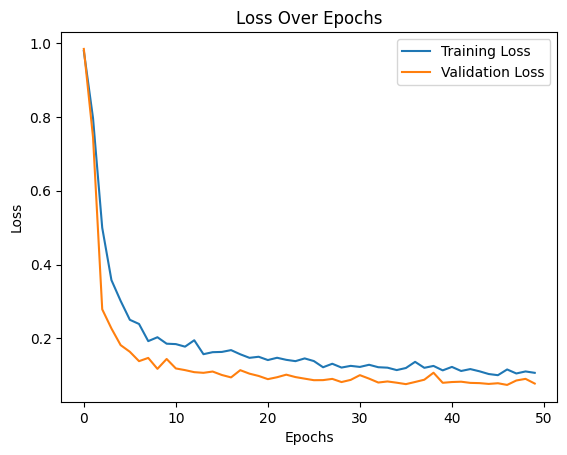

In [223]:
import matplotlib.pyplot as plt

# Example: Assuming `history` is the result of model.fit()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## DEEP NN

In [224]:
# Define the DNN model
dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    Dropout(0.3),  # Prevent overfitting
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.2),
    Dense(32, activation='relu'),  # Hidden layer
    Dense(y_train.shape[1], activation='linear')  # Output layer (regression task)
])

# Compile the model
dnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = dnn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
17/17 [==============================] - 1s 13ms/step - loss: 0.9438 - mae: 0.7500 - val_loss: 0.5242 - val_mae: 0.5193
Epoch 2/50
17/17 [==============================] - 0s 4ms/step - loss: 0.5647 - mae: 0.5410 - val_loss: 0.2348 - val_mae: 0.3250
Epoch 3/50
17/17 [==============================] - 0s 4ms/step - loss: 0.3019 - mae: 0.4080 - val_loss: 0.1461 - val_mae: 0.2783
Epoch 4/50
17/17 [==============================] - 0s 4ms/step - loss: 0.2465 - mae: 0.3778 - val_loss: 0.1278 - val_mae: 0.2544
Epoch 5/50
17/17 [==============================] - 0s 4ms/step - loss: 0.1980 - mae: 0.3266 - val_loss: 0.1186 - val_mae: 0.2419
Epoch 6/50
17/17 [==============================] - 0s 3ms/step - loss: 0.1810 - mae: 0.3128 - val_loss: 0.1092 - val_mae: 0.2300
Epoch 7/50
17/17 [==============================] - 0s 4ms/step - loss: 0.1715 - mae: 0.3037 - val_loss: 0.1052 - val_mae: 0.2231
Epoch 8/50
17/17 [==============================] - 0s 4ms/step - loss: 0.1713 - mae: 0.3

In [225]:
dnn.save("Deep_NN_model.h5")

6/6 [==============================] - 0s 2ms/step - loss: 0.0715 - mae: 0.1832
Test Loss: 0.07154437899589539, Test MAE: 0.18316082656383514


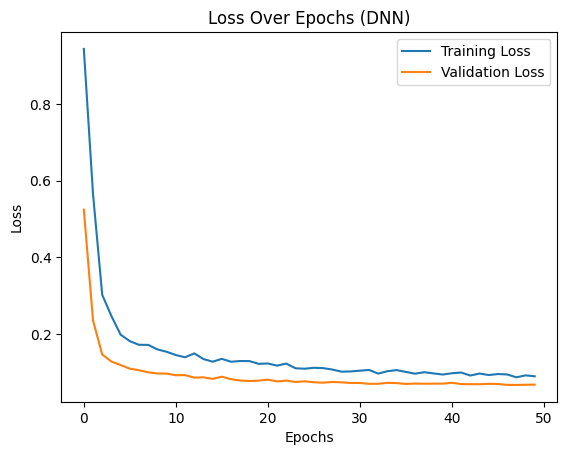

In [226]:
# Evaluate the model
test_loss, test_mae = dnn.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs (DNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [227]:
dnn_preds = dnn.predict(X_test)
dnn_mae = mean_absolute_error(y_test, dnn_preds)
dnn_mse = mean_squared_error(y_test, dnn_preds)
dnn_rmse = np.sqrt(dnn_mse)
dnn_r2 = r2_score(y_test, dnn_preds)

6/6 [==============================] - 0s 2ms/step


## Improvement


To improve we will create a more complex model, and change hyperparameters

In [228]:
model_dnn_improve = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(128, activation = 'relu'),
    Dropout(0.3),
    Dense(64, activation = 'relu'),
    Dense(y_train.shape[1], activation = 'linear')
])

model_dnn_improve.compile(optimizer = 'Adam', loss= 'mse', metrics = 'mae')

history_improve_dnn = model_dnn_improve.fit(X_train, y_train, validation_split = 0.2, epochs = 50, batch_size = 32)



Epoch 1/50
17/17 [==============================] - 1s 16ms/step - loss: 0.4865 - mae: 0.5082 - val_loss: 0.1777 - val_mae: 0.3030
Epoch 2/50
17/17 [==============================] - 0s 5ms/step - loss: 0.2120 - mae: 0.3436 - val_loss: 0.1188 - val_mae: 0.2393
Epoch 3/50
17/17 [==============================] - 0s 6ms/step - loss: 0.1616 - mae: 0.2908 - val_loss: 0.1077 - val_mae: 0.2295
Epoch 4/50
17/17 [==============================] - 0s 7ms/step - loss: 0.1513 - mae: 0.2816 - val_loss: 0.0981 - val_mae: 0.2170
Epoch 5/50
17/17 [==============================] - 0s 6ms/step - loss: 0.1409 - mae: 0.2693 - val_loss: 0.0910 - val_mae: 0.2026
Epoch 6/50
17/17 [==============================] - 0s 5ms/step - loss: 0.1286 - mae: 0.2554 - val_loss: 0.0867 - val_mae: 0.2024
Epoch 7/50
17/17 [==============================] - 0s 5ms/step - loss: 0.1190 - mae: 0.2468 - val_loss: 0.0820 - val_mae: 0.1929
Epoch 8/50
17/17 [==============================] - 0s 5ms/step - loss: 0.1130 - mae: 0.2

6/6 [==============================] - 0s 2ms/step - loss: 0.0631 - mae: 0.1718
Test Loss: 0.06308311223983765, Test MAE: 0.17184384167194366


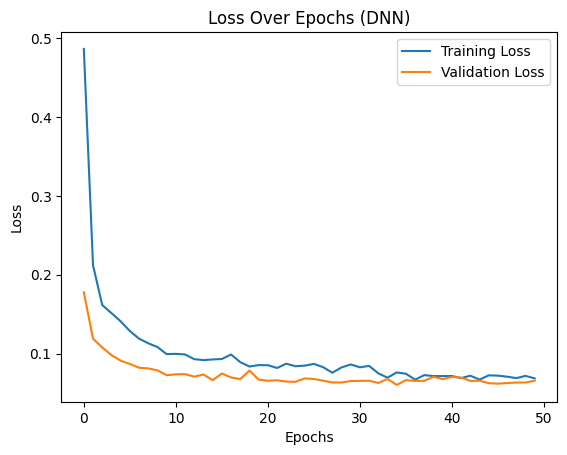

In [229]:
# Evaluate the model
test_loss, test_mae = model_dnn_improve.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Plot the loss
plt.plot(history_improve_dnn.history['loss'], label='Training Loss')
plt.plot(history_improve_dnn.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs (DNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

change rnn to lstm

In [230]:
from tensorflow.keras.layers import LSTM


model_rnn_improve = Sequential([
    LSTM(128, activation='relu', input_shape=(5, 3)),
    Dropout(0.2),
    Dense(64, activation = 'relu'),
    Dropout(0.3),
    Dense(32, activation = 'relu'),
    Dense(y_train.shape[1], activation='linear')
])

model_rnn_improve.compile(optimizer = 'Adam', loss = 'mse', metrics = 'mae')

history_improve_rnn = model_rnn_improve.fit(X_train_RNN, y_train_RNN, validation_split= 0.2, epochs = 50, batch_size = 32)



Epoch 1/50
17/17 [==============================] - 2s 25ms/step - loss: 0.9327 - mae: 0.7621 - val_loss: 0.9872 - val_mae: 0.7690
Epoch 2/50
17/17 [==============================] - 0s 8ms/step - loss: 0.6640 - mae: 0.6320 - val_loss: 0.4081 - val_mae: 0.4734
Epoch 3/50
17/17 [==============================] - 0s 8ms/step - loss: 0.3922 - mae: 0.4662 - val_loss: 0.3171 - val_mae: 0.4151
Epoch 4/50
17/17 [==============================] - 0s 8ms/step - loss: 0.2760 - mae: 0.3969 - val_loss: 0.2517 - val_mae: 0.3535
Epoch 5/50
17/17 [==============================] - 0s 11ms/step - loss: 0.2430 - mae: 0.3652 - val_loss: 0.2273 - val_mae: 0.3333
Epoch 6/50
17/17 [==============================] - 0s 9ms/step - loss: 0.2054 - mae: 0.3373 - val_loss: 0.2140 - val_mae: 0.3267
Epoch 7/50
17/17 [==============================] - 0s 9ms/step - loss: 0.2066 - mae: 0.3334 - val_loss: 0.1855 - val_mae: 0.2956
Epoch 8/50
17/17 [==============================] - 0s 9ms/step - loss: 0.1816 - mae: 0.

6/6 [==============================] - 0s 6ms/step - loss: 0.0809 - mae: 0.1985
Test Loss: 0.08092784881591797, Test MAE: 0.19849589467048645


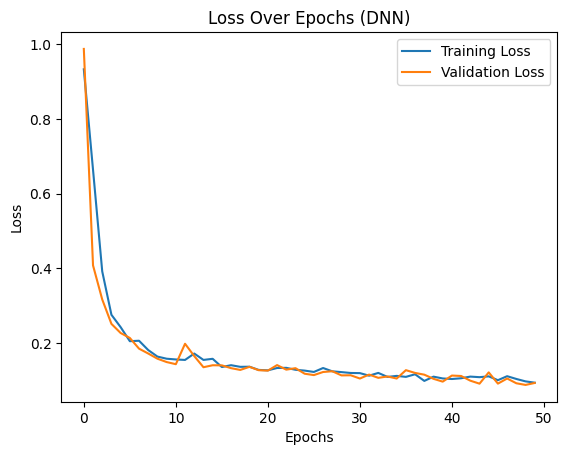

In [231]:
# Evaluate the model
test_loss, test_mae = model_rnn_improve.evaluate(X_test_RNN, y_test_RNN)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Plot the loss
plt.plot(history_improve_rnn.history['loss'], label='Training Loss')
plt.plot(history_improve_rnn.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs (DNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()